In [1]:
import torch
from torch import nn

import torch.functional as F
import torchvision.transforms.functional as TF
import torch.utils.checkpoint as checkpoint

from PIL import Image

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import numpy as np
import random

import requests
import io

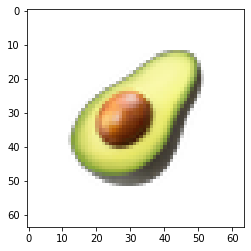

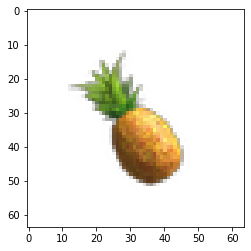

In [2]:
def load_image(url, max_size=40, padding=12):
    r = requests.get(url)
    img = Image.open(io.BytesIO(r.content))
    img.thumbnail((max_size, max_size), Image.ANTIALIAS)
    img = np.float32(img)/255.0
    img = np.pad(img,((padding,padding),(padding,padding),(0,0)))
    
    img[..., :3] *= img[..., 3:]
    
    img = torch.Tensor(img).float().cuda()
    img = img.transpose(0,2)

    return img


def load_emoji(emoji):
    code = hex(ord(emoji))[2:].lower()
    url = 'https://raw.githubusercontent.com/iamcal/emoji-data/master/img-apple-64/%s.png' % code
    return load_image(url)


avocado = load_emoji("🥑")
pineapple = load_emoji("🍍")

plt.imshow(avocado.transpose(0,2).cpu())
plt.show()
plt.imshow(pineapple.transpose(0,2).cpu())
plt.show()

img_size = 64

In [3]:
class Automata(nn.Module):

    def __init__(self, grid_size, n_channels):

        super(Automata, self).__init__()

        self.n_channels = n_channels
        self.grid_size = grid_size

        self.filters = torch.Tensor([[[[-1, 0, 1],
                                       [-2, 0, 2],
                                       [-1, 0, 1]
                                       ]],
                                     [[[-1, -2, -1],
                                       [0, 0, 0],
                                       [1, 2, 1]
                                       ]],
                                     [[[0, 0, 0],
                                       [0, 1, 0],
                                       [0, 0, 0]
                                       ]]]).cuda()

        self.mapper = nn.Sequential(
            nn.Linear(3*n_channels, 256),
            nn.ReLU(),
            nn.Linear(256, n_channels),
            nn.Tanh()
        )

        self.mapper[2].weight.data.fill_(0)
        self.mapper[2].bias.data.fill_(0)

    def perception(self, x):

        # reshape for same convolution across channels
        x = x.reshape(-1, 1, self.grid_size[0], self.grid_size[1])

        # toroidal padding
        conved = nn.functional.pad(x, (1, 1, 1, 1), mode="circular")

        conved = nn.functional.conv2d(conved, model.filters)

        # reshape for perception computations
        conved = conved.view(self.batch_size, 3*self.n_channels, -1)
        conved = conved.transpose(1, 2)

        conved = self.mapper(conved)

        conved = conved.transpose(1, 2)
        # (batch_size, channels, total_cells)

        conved = conved.view(self.batch_size, self.n_channels, *self.grid_size)

        can_update = torch.rand_like(conved) < 0.5

        return conved*can_update

    def forward(self, x, iterations, keep_history=False):

        if keep_history:

            model.history = torch.zeros(iterations, *x.shape)

        model.batch_size = x.shape[0]
        
        x.requires_grad = True

        for i in range(iterations):

            x = x + checkpoint.checkpoint(self.perception,x)
#             x = x+self.perception(x)

            is_alive = nn.functional.max_pool2d(
                x[:, 3], (3, 3), stride=1, padding=1) > 1/8

            is_alive = is_alive.unsqueeze(1)

            x = x*is_alive

            x[:, :4].clamp_(0, 1)

            if keep_history:

                model.history[i] = x.detach()

        return x

In [4]:
n_channels = 16
n_epochs = 2500
lr = 0.001
pool_size = 1024
batch_size = 16

image_1 = avocado
image_2 = pineapple

images = torch.stack([image_1,image_2])

model = Automata((64, 64), n_channels).cuda()

# initialize pool with seeds
seed = torch.zeros(n_channels,img_size,img_size).cuda()
seed[3:,32,32] = 1

seed_1 = seed.clone()
seed_2 = seed.clone()

seed_1[4,32,32] = 0

seeds = torch.stack([seed_1,seed_2])

pool_initials = seeds.repeat(pool_size//2,1,1,1)
pool_targets = images.repeat(pool_size//2,1,1,1)

pool_target_ids = torch.Tensor([0,1]).repeat(pool_size//2).long()
# 0 for image_1, 1 for image_2
# half image 1, half image 2

losses = []

criterion = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for i in range(n_epochs):
    
    iterations = random.randint(64,96)

    pool_indices = torch.Tensor(random.sample(range(pool_size),batch_size)).long()
        
    initial_states = pool_initials[pool_indices]
    targets = pool_targets[pool_indices]
    target_ids = pool_target_ids[pool_indices]

    out = model(initial_states,iterations)
    
    phenotypes = out[:,:4].squeeze()

    optimizer.zero_grad()

    loss = criterion(phenotypes, targets)
    
    per_sample_loss = loss.mean((1,2,3))
    total_loss = per_sample_loss.mean()

    total_loss.backward()
    optimizer.step()
    
    # argsort the losses per sample
    ranked_loss = per_sample_loss.argsort()
    
    # get indices of min- and max-loss samples
    min_loss_indices = ranked_loss[:batch_size//2]
    max_loss_indices = ranked_loss[batch_size//2:]
    
    replacements = out.detach()
    
    max_loss_targets = target_ids[max_loss_indices]
    
    # high-loss outputs are re-tasked with
    # mapping the seeds to the respective image
    
    # low-loss outputs are tasked with mapping
    # the previous output to the same image
    
    replacements[max_loss_indices] = seeds[max_loss_targets]
    pool_initials[pool_indices] = replacements
    
    if i % 100 == 0:
    
        print(i, np.log10(float(total_loss.cpu().detach())))
        
    losses.append(float(total_loss))

0 -1.0639483348134933
100 -1.2494121605622668
200 -1.2797147192306855
300 -1.34503031532299
400 -1.3907041078061837
500 -1.4725516012985969
600 -1.66562713876753
700 -1.5745633272980664
800 -1.6701617661168597
900 -1.892811150023907
1000 -1.9657650961056954
1100 -1.9531560900998948
1200 -2.010901051144486
1300 -2.0261587663645235
1400 -2.065005544214205
1500 -2.07176380217664
1600 -1.9818533498757043
1700 -2.025773089661547
1800 -2.0426330230185754
1900 -2.0951746046972235
2000 -2.0768514852379094
2100 -2.148457702044759
2200 -2.058519460850051
2300 -2.2541579091912762
2400 -2.0990346451361352


In [13]:
for i in range(n_epochs):
    
    iterations = random.randint(64,96)

    pool_indices = torch.Tensor(random.sample(range(pool_size),batch_size)).long()
        
    initial_states = pool_initials[pool_indices]
    targets = pool_targets[pool_indices]
    target_ids = pool_target_ids[pool_indices]

    out = model(initial_states,iterations)
    
    phenotypes = out[:,:4].squeeze()

    optimizer.zero_grad()

    loss = criterion(phenotypes, targets)
    
    per_sample_loss = loss.mean((1,2,3))
    total_loss = per_sample_loss.mean()

    total_loss.backward()
    optimizer.step()
    
    # argsort the losses per sample
    ranked_loss = per_sample_loss.argsort()
    
    # get indices of min- and max-loss samples
    min_loss_indices = ranked_loss[:batch_size//2]
    max_loss_indices = ranked_loss[batch_size//2:]
    
    replacements = out.detach()
    
    max_loss_targets = target_ids[max_loss_indices]
    
    # high-loss outputs are re-tasked with
    # mapping the seeds to the respective image
    
    # low-loss outputs are tasked with mapping
    # the previous output to the same image
    
    replacements[max_loss_indices] = seeds[max_loss_targets]
    pool_initials[pool_indices] = replacements
    
    if i % 100 == 0:
    
        print(i, np.log10(float(total_loss.cpu().detach())))
        
    losses.append(float(total_loss))

0 -2.035031403400865
100 -2.1829525158673557
200 -2.0550722755403816
300 -2.016663227395762
400 -2.2220821867504954
500 -2.216173282478716
600 -2.2034154465423446
700 -2.214328399592685
800 -2.300470016224751
900 -2.1684135343414463
1000 -2.185843617248847
1100 -2.179555466017513
1200 -2.160643193181155
1300 -2.124144504126838
1400 -2.2408405695838796
1500 -1.5978986251210727
1600 -1.9987173549237538
1700 -1.9766205920507165
1800 -2.0734830534142374
1900 -1.9287168649792292
2000 -2.1857003719535872
2100 -2.0667843682977596
2200 -2.1285784495196163
2300 -2.169485040914946
2400 -2.2256858155606296


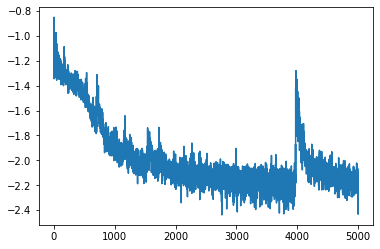

In [14]:
plt.plot(np.log10(losses))

In [15]:
seed_3 = seed.clone()
seed_3[4,32,32] = 0.5

In [18]:
with torch.no_grad():
    out = model(seed_1[None,:],1024,keep_history=True)
    video = model.history.cpu().detach()
    video = video[:,0,:4]
    video = video.transpose(1,3)

/home/khu/anaconda3/envs/cenv/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [19]:
from matplotlib import animation
from IPython.display import HTML

fig = plt.figure()
im = plt.imshow(video[0,:,:,:])

plt.close()

def init():
    im.set_data(video[0,:,:,:])

def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init,  frames=video.shape[0],
                               interval=50)
HTML(anim.to_html5_video())